# Train and Verify

This example is adapted from the PyTorch example ["Training a Classifier"](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using torchvision

2. Define a Convolutional Neural Network

3. Define a loss function

4. Train the network on the training data

5. Test the network on the test data

## Load and normalize CIFAR10

Using torchvision, it’s extremely easy to load CIFAR10.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

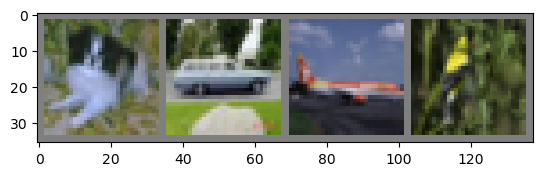

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels

## Define a Neural Network

Since we only support fully connected layers, we will use a simple neural network and view the input image as a 1D tensor.


In [4]:
import sys

sys.path.append('..')

import torchpoly.nn as nn


net = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

## Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.nn as torch_nn
import torch.optim as optim

criterion = torch_nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.view(-1, 3 * 32 * 32))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.183
[1,  4000] loss: 1.887
[1,  6000] loss: 1.750
[1,  8000] loss: 1.702
[1, 10000] loss: 1.636
[1, 12000] loss: 1.587
[2,  2000] loss: 1.532
[2,  4000] loss: 1.511
[2,  6000] loss: 1.489
[2,  8000] loss: 1.478
[2, 10000] loss: 1.456
[2, 12000] loss: 1.425
Finished Training


Let’s quickly save our trained model:

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

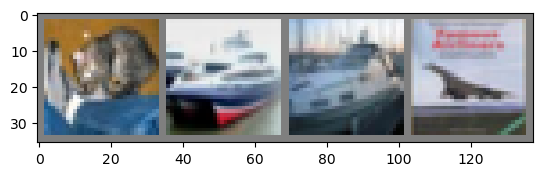

GroundTruth:  cat   ship  ship  plane


In [8]:
net.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Verify the network

We have checked the network on the test data. Now let's verify the network on the test data.

In [19]:
import torchpoly
import torchpoly.cert as cert

image = images[0].view(-1, 3 * 32 * 32).squeeze(0).to(device)

lb = image - 0.1
ub = image + 0.1

A = torch.tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]], device=device, dtype=torch.float32)
b = torch.tensor([0], device=device, dtype=torch.float32)

bound = cert.Ticket.from_bound(lb, ub).to(device)
verifier = torchpoly.Verifier(A, b, device=device)

print(verifier(net, bound, device=device))


VerifyResult.UNKNOWN
